# Анализ поведения клиентов на примере сайта GB

## Этап 1. Загрузка данных. Проверка корректности типов данных

Самый интересный параметр в данном датасете claim (признак отправки формы), в связи с этим все исследования будем строить вокруг этого параметра

In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [191]:
ds = pd.read_csv('./gb_dataset.csv')
ds.head()

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,gender,age,touch_screen,has_vk_id,has_ok_id
0,4358a11f0d16be6e,0,0,1,2021-12-01,https://gb.ru/education,https://gb.ru/comms/calendar,NaN,NaN,0,39,1,1,0
1,133509b7ff9a586c,0,0,0,2021-12-01,https://www.google.com/,https://gb.ru/courses/programming,google,cpc,-1,-1,2,0,0
2,8b23cd36f2b08dcd,0,0,0,2021-12-01,https://gb.ru/tests/352/trials/2238911/run,https://gb.ru/tests/352/trials/2238911,NaN,NaN,1,49,1,1,1
3,50de4c060fd128f3,0,1,1,2021-12-01,https://gb.ru/courses/1165,https://gb.ru/a/a1,NaN,NaN,-1,-1,1,1,0
4,c2ca3cc9a67c749b,0,0,0,2021-12-01,NaN,https://gb.ru/login,NaN,NaN,0,23,2,1,0


In [192]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   session_id    884407 non-null  object
 1   claim         884407 non-null  int64 
 2   60sec         884407 non-null  int64 
 3   scroll_90     884407 non-null  int64 
 4   hit_date      884407 non-null  object
 5   referer_url   687598 non-null  object
 6   url           884407 non-null  object
 7   utm_source    245184 non-null  object
 8   utm_medium    244863 non-null  object
 9   gender        884407 non-null  int64 
 10  age           884407 non-null  int64 
 11  touch_screen  884407 non-null  int64 
 12  has_vk_id     884407 non-null  int64 
 13  has_ok_id     884407 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 94.5+ MB


In [193]:
ds.describe()

,claim,60sec,scroll_90,gender,age,touch_screen,has_vk_id,has_ok_id
count,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000
mean,0.002071,0.313425,0.144197,-0.359456,14.844552,1.436307,0.449500,0.124044
std,0.045466,0.463886,0.351290,0.808853,21.505421,0.495927,0.497444,0.329631
min,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,29.000000,2.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,120.000000,2.000000,1.000000,1.000000


In [194]:
print('Количество уникальных сессий: ', ds['session_id'].nunique())
print('Всего сессии: ',ds['session_id'].count())

Количество уникальных сессий:  864092
Всего сессии:  884407


In [195]:
from collections import Counter
c = Counter(list(ds['session_id']))
print(len([i for i in c if c[i] > 1]))
print(len([i for i in c if c[i] > 2]))

20085
194


## Этап 2. Исследовательский анализ данных

In [196]:
# Проверим типы данных
ds.dtypes

session_id      object
claim            int64
60sec            int64
scroll_90        int64
hit_date        object
referer_url     object
url             object
utm_source      object
utm_medium      object
gender           int64
age              int64
touch_screen     int64
has_vk_id        int64
has_ok_id        int64
dtype: object

In [197]:
ds[['60sec','scroll_90','has_ok_id','has_vk_id','claim']] = ds[['60sec','scroll_90','has_ok_id','has_vk_id','claim']].astype(bool)
ds[['referer_url','url','utm_source','utm_medium']] = ds[['referer_url','url','utm_source','utm_medium']].astype(str)
ds['hit_date'] = pd.to_datetime(ds['hit_date'])
origin_ds = ds.copy()
ds.dtypes

session_id              object
claim                     bool
60sec                     bool
scroll_90                 bool
hit_date        datetime64[ns]
referer_url             object
url                     object
utm_source              object
utm_medium              object
gender                   int64
age                      int64
touch_screen             int64
has_vk_id                 bool
has_ok_id                 bool
dtype: object

Разделим переходы на 3 категории
- direct Прямой заход на сайт или переход с другой страницы сайта
- ad Рекламный переход
- search Переход из поиска

Так же выделим основные типы страниц
- courses Страница отдельного курса или списка курсов
- edufree Бесплатные программы обучения
- events Страница события
- geek_university Страница факультета
- posts Страница поста
- partners Партнерские страницы
- other Другие страницы

In [198]:
def get_row_category(row):
    # print(row.referer_url)
    if 'gb.ru' in row.referer_url or not row.referer_url:
        return 0#'direct'
    if row.utm_source and row.utm_medium and row.utm_medium == 'email' and 'gb.ru' not in row.referer_url:
        return 3#'email'
    if row.utm_source and row.utm_medium and 'gb.ru' not in row.referer_url:
        return 1#'ad'
    return 2#'search'

def get_row_url_type(row):
    if '/courses' in row.url or '/it_dao' in row.url or '/geek-school' in row.url:
        return 0#'courses'
    if '/edufree' in row.url or '/start_digital' in row.url:
        return 1#'edufree'
    if '/events/' in row.url:
        return 2#'events'
    if '/geek_university/' in row.url or '/professions/' in row.url:
        return 3#'geek_university'
    if '/posts/' in row.url:
        return 4#'posts'
    if '/partners/' in row.url:
        return 5#'partners'
    if '/career' in row.url:
        return 8#'career'
    if row.url == 'https://gb.ru/':
        return 7# index
    return 6#'other'

page_type_dict = {0:'courses', 1:'edufree',2:'events',3:'geek_university',4:'posts',5:'partners',6:'other', 7:'index', 8:'career'}
visit_type_dict = {0:'direct',1:'ad',2:'search', 3:'email'}
# print(ds['utm_source'].unique())
# print(ds['utm_medium'].unique())
ds['visit_type'] = ds.apply(get_row_category, axis=1)
ds['page_type'] = ds.apply(get_row_url_type, axis=1)
ds = ds.drop(['session_id', 'utm_medium', 'utm_source', 'url','referer_url'], axis=1)
# Остальные страницы можно вырезать, т.к. они не представляют интереса или не имеют форм обратной связи
ds = ds.loc[ds['page_type']!=6]

Разделим пользователей по возрастным группам
- менее 20 лет
- от 20 до 30
- от 30 до 40
- от 40 до 50
- более 50

In [199]:
def age_group(row):
    if row.age == -1:
        return -1
    if row.age < 20:
        return 0 # '< 20'
    elif 20 <= row.age < 30:
        return 1 # 20 - 30
    elif 30 <= row.age < 40:
        return 2 # 30 - 40
    elif 40 <= row.age < 50:
        return 3 # 40 - 50
    else:
        return 4 # > 50

age_group_keys = {0:'< 20', 1:'20 - 30', 2:'30 - 40', 3:'40 - 50', 4: '> 50'}
ds['age_group'] = ds.apply(age_group, axis=1)

In [200]:
ds.head()

,claim,60sec,scroll_90,hit_date,gender,age,touch_screen,has_vk_id,has_ok_id,visit_type,page_type,age_group
1,False,False,False,2021-12-01,-1,-1,2,False,False,1,0,-1
5,False,True,True,2021-12-01,1,68,1,True,True,0,0,4
6,False,True,True,2021-12-01,-1,-1,2,True,False,1,2,-1
9,False,False,False,2021-12-01,1,26,1,True,False,0,0,1
10,False,True,False,2021-12-01,1,62,2,False,True,1,1,4


In [202]:
# Обнаружение пропусков
ds.isnull().sum()

claim           0
60sec           0
scroll_90       0
hit_date        0
gender          0
age             0
touch_screen    0
has_vk_id       0
has_ok_id       0
visit_type      0
page_type       0
age_group       0
dtype: int64

<AxesSubplot:xlabel='age'>

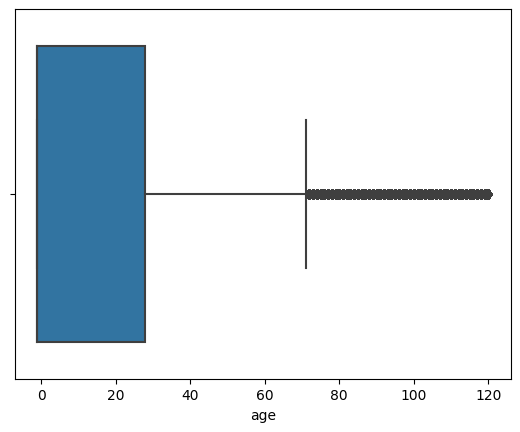

In [203]:
# Поиск выбросов и аномалий
sns.boxplot(ds['age'])

In [223]:
ds['age'] = ds['age'].apply(lambda x: -1 if x > 75 else x)

,claim,60sec,scroll_90,gender,age,touch_screen,has_vk_id,has_ok_id,visit_type,page_type,age_group
claim,1.000000,0.045950,0.029119,-0.028551,-0.028463,-0.030757,-0.029276,-0.017259,0.006032,-0.018500,-0.028447
60sec,0.045950,1.000000,0.114692,0.027896,0.019365,-0.073184,0.009363,0.014558,-0.053655,-0.106417,0.019109
scroll_90,0.029119,0.114692,1.000000,0.023023,0.051217,0.049101,-0.002590,0.059919,0.073020,-0.157795,0.052179
gender,-0.028551,0.027896,0.023023,1.000000,0.832518,-0.109337,0.658214,0.451418,-0.001603,-0.038501,0.836300
age,-0.028463,0.019365,0.051217,0.832518,1.000000,-0.072856,0.578738,0.555559,0.024476,-0.069333,0.938559
touch_screen,-0.030757,-0.073184,0.049101,-0.109337,-0.072856,1.000000,-0.170750,0.047307,0.190876,-0.239879,-0.072065
has_vk_id,-0.029276,0.009363,-0.002590,0.658214,0.578738,-0.170750,1.000000,0.239551,-0.048265,0.041704,0.583152
has_ok_id,-0.017259,0.014558,0.059919,0.451418,0.555559,0.047307,0.239551,1.000000,0.074383,-0.119681,0.565644
visit_type,0.006032,-0.053655,0.073020,-0.001603,0.024476,0.190876,-0.048265,0.074383,1.000000,-0.038077,0.027178
page_type,-0.018500,-0.106417,-0.157795,-0.038501,-0.069333,-0.239879,0.041704,-0.119681,-0.038077,1.000000,-0.069900


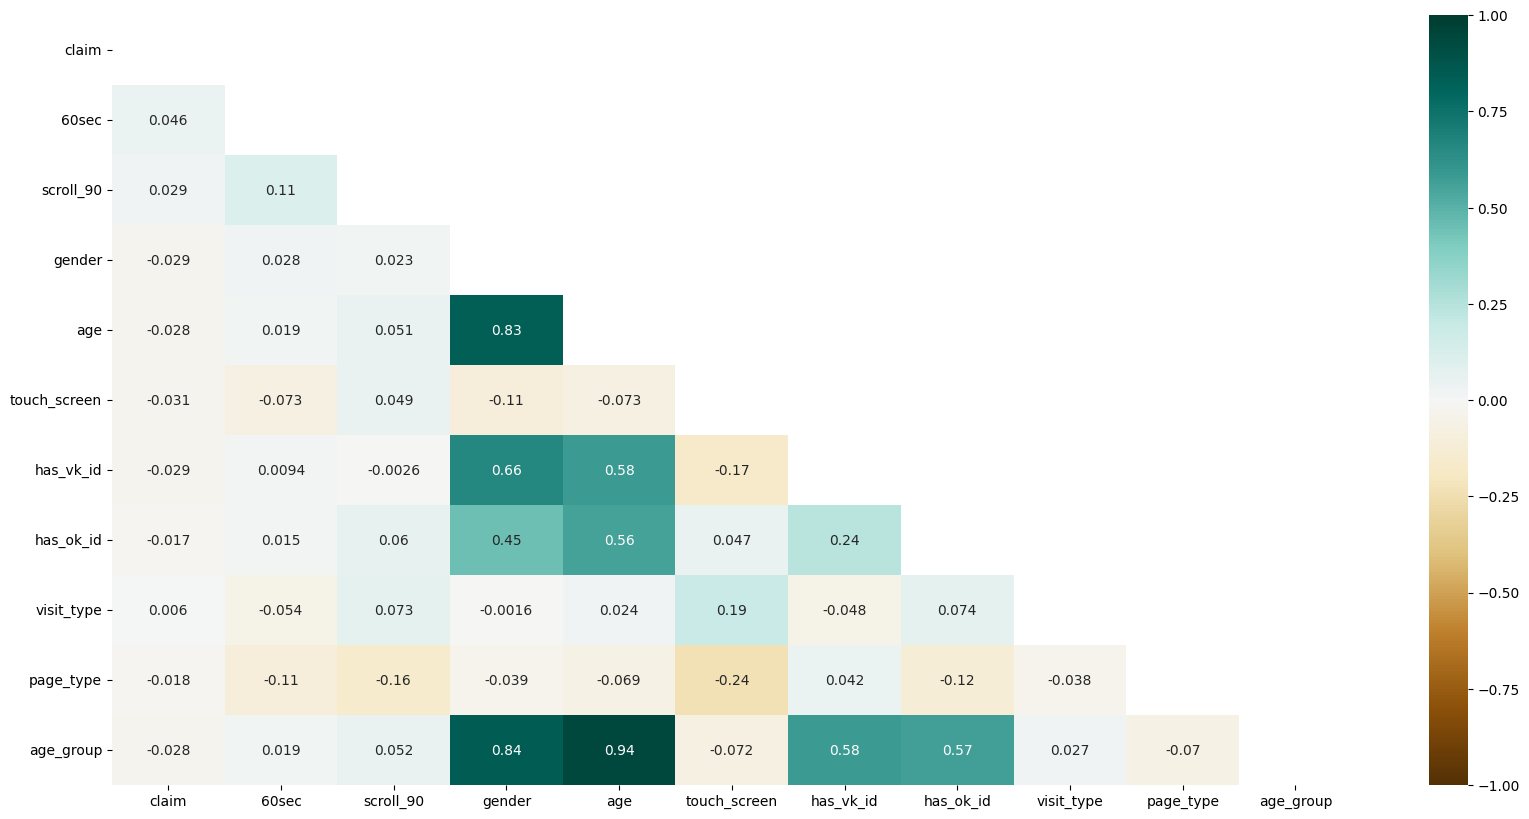

In [205]:
plt.figure(figsize=(20,10))
c= ds.corr()
cor_matrix_mask = np.triu(np.ones_like(c, dtype=bool))
sns.heatmap(c,cmap="BrBG",annot=True, vmin=-1, vmax=1, mask=cor_matrix_mask)
c

In [206]:
## Этап 3. Статистический анализ данных

Text(0, 0.5, 'Количество отправок форм по типам страниц')

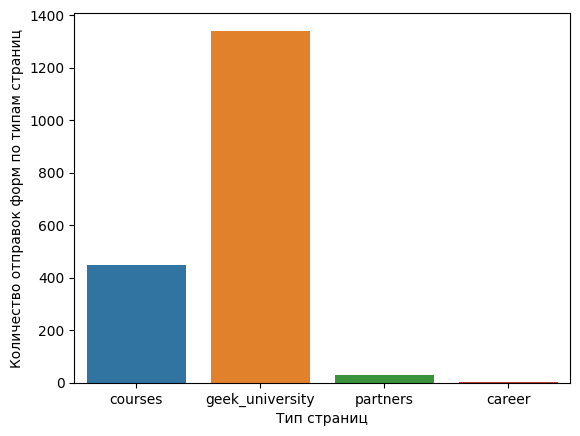

In [207]:
c = ds[ds.claim==True].groupby('page_type')['page_type'].count().to_frame('counts').reset_index()
c['page_type'] = c['page_type'].replace(page_type_dict)

sns.barplot(x=c.page_type, y=c.counts)
plt.xlabel('Тип страниц')
plt.ylabel('Количество отправок форм по типам страниц')

Text(0, 0.5, 'Количество отправок форм по источнику трафика')

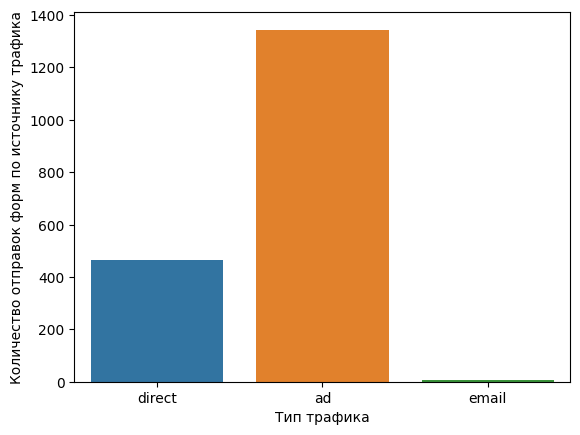

In [208]:
c = ds[ds.claim==True].groupby('visit_type')['visit_type'].count().to_frame('counts').reset_index()
c['visit_type'] = c['visit_type'].replace(visit_type_dict)

sns.barplot(x=c.visit_type, y=c.counts)
plt.xlabel('Тип трафика')
plt.ylabel('Количество отправок форм по источнику трафика')

In [209]:
# Добавим параметр проявления интереса к странице
ds['interes'] = ds[['60sec','scroll_90']].apply(lambda x: x['60sec'] and x['scroll_90'], axis=1)

,page_type,interes,counts
1,courses,True,5703
3,edufree,True,6782
5,events,True,1602
7,geek_university,True,9282
9,posts,True,3262
11,partners,True,564
13,index,True,1364
15,career,True,711


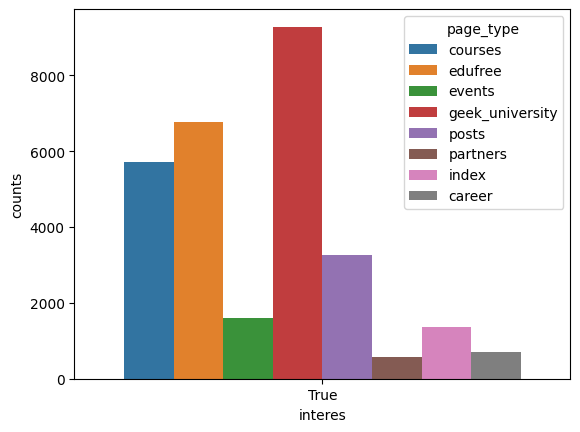

In [210]:
c = ds[['page_type', 'interes']].groupby(['page_type','interes']).size()
c = c.to_frame('counts').reset_index()
c = c[c['page_type']!=6]
c = c[c['interes']==True]
c['page_type'] = c['page_type'].replace(page_type_dict)
sns.barplot(data=c, hue='page_type', x='interes', y='counts')
c

Проверим использование соц сетей по возрасту

In [211]:

tmp_ds = ds.copy()
tmp_ds = tmp_ds.loc[~((tmp_ds['age']==-1) | (tmp_ds['gender']==-1))]
tmp_ds = tmp_ds.replace({'gender': {0:'Male', 1:'Female'}})

Text(0.5, 1.0, 'Использования Одноклассноков по возрастам')

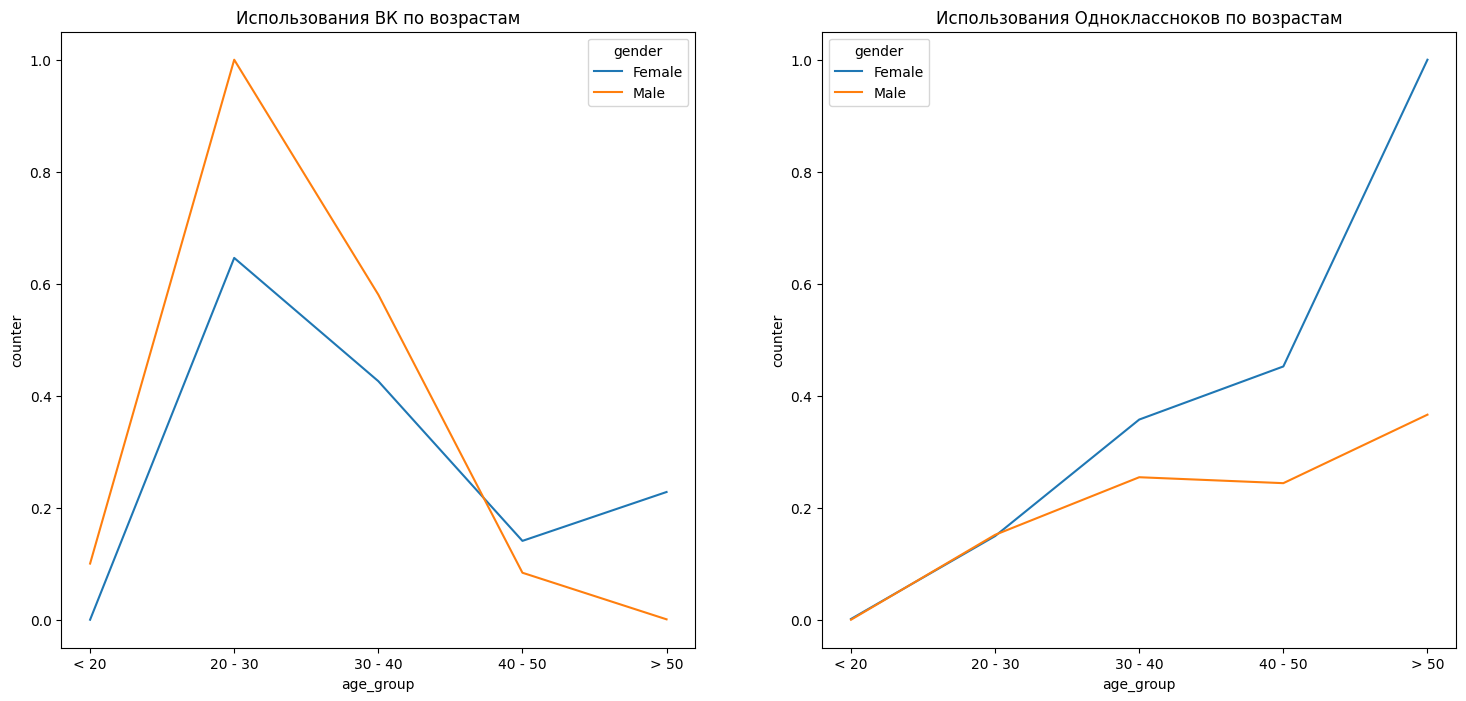

In [212]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
vk_plot_data = tmp_ds[tmp_ds['has_vk_id']==True].sort_values('age_group').groupby(['gender','age_group']).size().to_frame('counter').reset_index().sort_values('age_group')
ok_plot_data = tmp_ds[tmp_ds['has_ok_id']==True].sort_values('age_group').groupby(['gender','age_group']).size().to_frame('counter').reset_index().sort_values('age_group')

vk_plot_data = vk_plot_data.replace({'age_group': age_group_keys})
ok_plot_data = ok_plot_data.replace({'age_group': age_group_keys})

vk_plot_data['counter'] = scaler.fit_transform(vk_plot_data[['counter']])
ok_plot_data['counter'] = scaler.fit_transform(ok_plot_data[['counter']])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
lp1 = sns.lineplot(x="age_group", y='counter', hue='gender',
                   data=vk_plot_data,
                   ax=axs[0])
lp2 = sns.lineplot(x="age_group", y='counter', hue='gender', data=ok_plot_data, ax=axs[1])
lp1.set_title('Использования ВК по возрастам')
lp2.set_title('Использования Одноклассноков по возрастам')

<AxesSubplot:xlabel='weekday', ylabel='counter'>

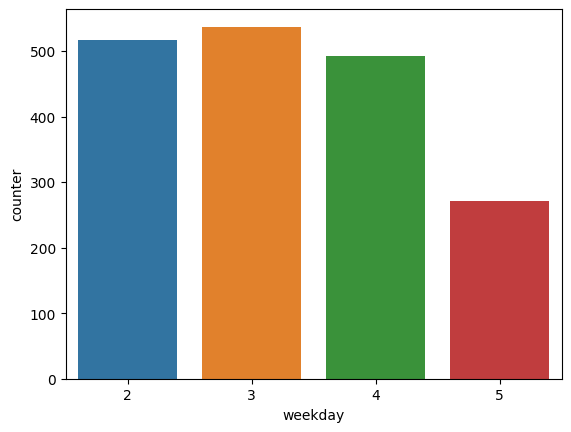

In [213]:
import calendar
del(tmp_ds)
del(vk_plot_data)
del(ok_plot_data)
# ds['weekday'] = ds['hit_date'].apply(lambda x: calendar.day_name[x.weekday()])
ds['weekday'] = ds['hit_date'].apply(lambda x: x.weekday())
sns.barplot(data=ds[ds['claim']==True].groupby('weekday').size().to_frame('counter').reset_index(), x='weekday', y='counter')
# Относительно ровно

Проверим какая возрастная группа чаще отправляет заявки

Text(0, 0.5, 'Количество отправок форм')

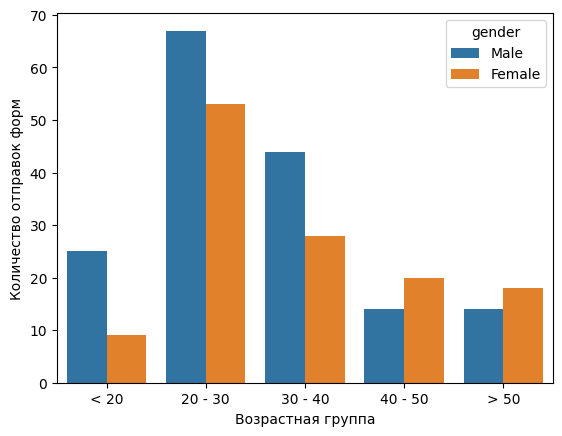

In [214]:
tmp_ds = ds[ds['gender']!=-1] # отсеим тех чей пол неизвестен
tmp_ds = tmp_ds[tmp_ds['claim']==True].groupby(['age_group','gender']).size().to_frame('counter').reset_index()

tmp_ds = tmp_ds.replace({'age_group': age_group_keys,'gender':{0:'Male', 1:'Female'}})
sns.barplot(data=tmp_ds, x='age_group', y='counter', hue='gender')

plt.xlabel('Возрастная группа')
plt.ylabel('Количество отправок форм')

Как видно из графика чаще всего формы отправляют люди от 20 до 40

## Этап 4. Предобработка данных (обработка пропусков, аномалий)

## Этап 5. Построение воронки клиентов

Воронка:
- всего пользователей с группировкой по источнику трафика
- проявили интерес к странице
- отправили заявку

In [215]:
quantity = []
# tmp_ds = ds[(ds['age_group'] == 1) | (ds['age_group'] == 2) ]
# tmp_ds = ds[ds['interes'] == True]
# print(set(ds['visit_type'].tolist()))
for vt in set(ds['visit_type'].tolist()):
    tmp = ds[ds['visit_type']==vt]
    quantity.append(tmp.shape[0])

    tmp = tmp[tmp['60sec']==True]
    quantity.append(tmp.shape[0])

    tmp = tmp[tmp['scroll_90']==True]
    quantity.append(tmp.shape[0])

    tmp = tmp[tmp['claim']==True]
    quantity.append(tmp.shape[0])
    # print(vt)
# ds[ds['visit_type']==0].shape[0]
quantity

[175169, 67295, 10702, 95, 325840, 102607, 17600, 289, 9517, 3447, 968, 2]

In [216]:
import plotly.express as px

data = dict(Quantity=quantity,
            Stage=['Всего пользователей', '60 сек', 'Скролл 90%', 'Отправили заявку']*3,
            Location= ['Директ']*4 + ['Рекламный трафик']*4 + ['Email']*4)

fig = px.funnel(data, y='Stage', x='Quantity', color='Location',
                color_discrete_map={"Рекламный трафик": "#374B53",
                                    "Директ": "#617588"},
                template="simple_white",
                title='Воронка продаж',
                labels={"Stage": ""})
fig.show()

Страшная воронка...

## Этап 6. Выявление инсайтов в данных

#### Какие действия клиенты GB совершают чаще всего?

In [217]:
origin_ds.groupby('url').size().to_frame('count').reset_index().sort_values('count', ascending=False)[:5]

,url,count
2042,https://gb.ru/education,150196
486,https://gb.ru/,126766
4468,https://gb.ru/s/edufree/besplatno,108939
2762,https://gb.ru/login,56082
1131,https://gb.ru/courses,17106


#### Есть ли аномалии в поведении пользователей: например, большое число коротких (менее 60 с.) сессий? С чем эти аномалии могут быть связаны?

In [218]:
origin_ds.groupby('60sec').size().to_frame('count').reset_index()

,60sec,count
0,False,607212
1,True,277195


In [219]:
ds.groupby('60sec').size().to_frame('count').reset_index()

,60sec,count
0,False,337177
1,True,173349


Для начала очень много событий с тестовых или локальных копий проекта, плюс тут собираются заходы администраторов, тестировщиков и прочего персонала, так же короткие сессии могут быть связанны с скликиванием рекламы ботами и соперниками или пользователями которые случайно зашли.

#### На каких страницах прокрутка 90% и более?

In [220]:
origin_ds[origin_ds['scroll_90'] == True].groupby('url').size().to_frame('count').reset_index().sort_values('count', ascending=False)[:5]

,url,count
1735,https://gb.ru/s/edufree/besplatno,26975
272,https://gb.ru/comms/chat,13277
643,https://gb.ru/education,12438
95,https://gb.ru/a/m7,8061
271,https://gb.ru/comms/calendar,5647


И опять в топе страницы бесплатных курсов, и почему то чат, хотя чат открывается в полноэкраном режиме без скрола (не считая внутренего с сообщениями).
По моему на таких страницах как календарь, чат считать скролл крайне странное решение

#### В какие даты было больше всего сессий? Рассчитайте DAU, MAU, WAU.
Статистика всего за 4 дня :)

In [221]:
origin_ds.groupby('hit_date').size().to_frame('count').reset_index().sort_values('count', ascending=False)

,hit_date,count
1,2021-12-02,250158
0,2021-12-01,227725
3,2021-12-04,211636
2,2021-12-03,194888


Больше всего сессий было 2021-12-02

#### Какие изменения на сайте могут улучшить показатели: число посещений, длительность сессии и другие?
Тут перед тем как делать выводы о улучшении сайта необходимо получить нормальный лог, параметров крайне мало и многие не информативны.
Улучшить лог достаточно просто, сделать привязку к пользователю а не к сессии, считать не просто длительность 60 сек, а длительность всей сессии, или добавить ещё 2 поля 30сек, 5сек, таким образом можно будет сразу убрать кучу мусора в виде сессий которые длились меньше 15 секунд. Так же лучше использовать не просто параметр тачскрин, а устройство с которого зашел пользователь, там сразу неопеределнность с тачскрином пропадёт.
По поводу использования пользователей вместо сессий ситуация решается просто, используется или ид пользователя, если он залогинен, или используется технология browser fingerprint для анонимов

Как можно видеть по графикам выше больше всего люди проявляют интерес не к отдельному курсу, а его набору или факультетам, а так же к бесплатным курсам. Для привлечения можно людей и увеличения конверсионости можно использовать таргетированную рекламу, как видим больше всего откликов у мужчин 20-40 лет. Так же, с учетом интереса к бесплатным курсам можно расширить их количество или сделать условно бесплатные курсы, т.е. давать бесплатный доступ до определенного момента.